# Datapipes Tutorial 2: gettings started with transforms


This tutorial covers the transform system in PhysicsNemo DataPipes.
You'll learn how to:

1. Apply a single transform (Normalize)
2. Compose multiple transforms together
3. Subsample point clouds with SubsamplePoints
4. Use geometric transforms (Translate, Scale)
5. Save/load normalization statistics from files
6. Denormalize data with the inverse() method

This tutorial will use synthetic data, similar to to the first tutorial.  We'll also use some data that has variable length data (similar to point cloud data) and for that, you can generate it with another script:


In [1]:
!python generate_variable_points_data.py -n 100 -s "coords:3 features:8" --min-points 50000 --max-points 100000 -b zarr -o output/pointcloud_data/

Parsing shape specifications...
Feature shapes: {'coords': (3,), 'features': (8,)}
Point range: 50,000 to 100,000

Generating point counts for 100 samples...
Mean points per sample: 72185
Total points across all samples: 7,218,485

Saving data to output/pointcloud_data using backend 'zarr'...
/Users/coreya/physicsnemo/examples/minimal/datapipes/generate_variable_points_data.py:224: ZarrDeprecationWarning: Use Group.create_array instead.
  root.create_dataset(
  Saved 10/100 samples...
  Saved 20/100 samples...
  Saved 30/100 samples...
  Saved 40/100 samples...
  Saved 50/100 samples...
  Saved 60/100 samples...
  Saved 70/100 samples...
  Saved 80/100 samples...
  Saved 90/100 samples...
  Saved 100/100 samples...
Saved 100 samples as zarr directories (317.61 MB total)
Metadata saved to output/pointcloud_data/metadata.json

Done!


In [2]:
import time
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import torch

# Import core datapipe components
from physicsnemo.datapipes import DataLoader, Dataset
from physicsnemo.datapipes.readers import ZarrReader

# Import transforms
from physicsnemo.datapipes.transforms import (
    Compose,
    Normalize,
    Scale,
    SubsamplePoints,
    Translate,
    CenterOfMass,
    Purge,
)

# For some histogramming:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rcParams.update(
    {
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "legend.fontsize": 13,
        "figure.titlesize": 18,
    }
)

data_path = "./output/tutorial_data/"

Warp DeprecationWarning: The namespace `warp.context` will soon be removed from the public API. It can still be accessed from `warp._src.context` but might be changed or removed without notice.
Warp DeprecationWarning: The symbol `warp.context.Device` will soon be removed from the public API. Use `warp.Device` instead.


## Section 1: Applying a Single Transform (Normalize)

Transforms operate on TensorDict objects and return modified TensorDicts.  Most transforms are stateless, but they don't need to be.  The first we'll encounter expects information on the dataset statistics.

The Normalize transform standardizes tensor values. It supports two methods:
- mean_std: map the mean and standard deviation to 0.0, 1.0, with `(x - mean) / std`
- min_max: scales [min, max] to [-1, 1] range with a linear transformation.



In [3]:
# Create reader and load a sample
reader = ZarrReader(path=data_path)
data, metadata = reader[0]

print("Before normalization:")
print(
    f"  velocity: mean={data['velocity'].mean():.4f}, std={data['velocity'].std():.4f}"
)
print(
    f"  pressure: mean={data['pressure'].mean():.4f}, std={data['pressure'].std():.4f}"
)
print()

Before normalization:
  velocity: mean=2.9993, std=5.7733
  pressure: mean=3.0023, std=5.7756



We'll make some histograms to see before / after of the data.  This is the same function from tutorial 1:

In [4]:
def make_histogram(x: torch.Tensor, bins=50):
    """
    Make a clean Plotly histogram for Jupyter notebooks.

    Parameters
    ----------
    x : array-like
        Data to histogram.
    bins : int, optional
        Number of bins
    """
    x = x.flatten().cpu().numpy()

    data_min = x.min()
    data_max = x.max()
    step = (data_max - data_min) / bins

    bins = np.arange(data_min, data_max + step, step)

    counts, bin_edges = np.histogram(x, bins)

    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_widths = bin_edges[1:] - bin_edges[:-1]

    fig = plt.figure(figsize=(16, 9))
    plt.bar(bin_centers, counts, width=bin_widths, zorder=3, edgecolor="black")

    max_count = counts.max()

    plt.ylim([0.0, 1.5 * max_count])
    plt.ylabel("Counts")
    plt.xlabel("Data Range")

    plt.grid(True)
    plt.show()

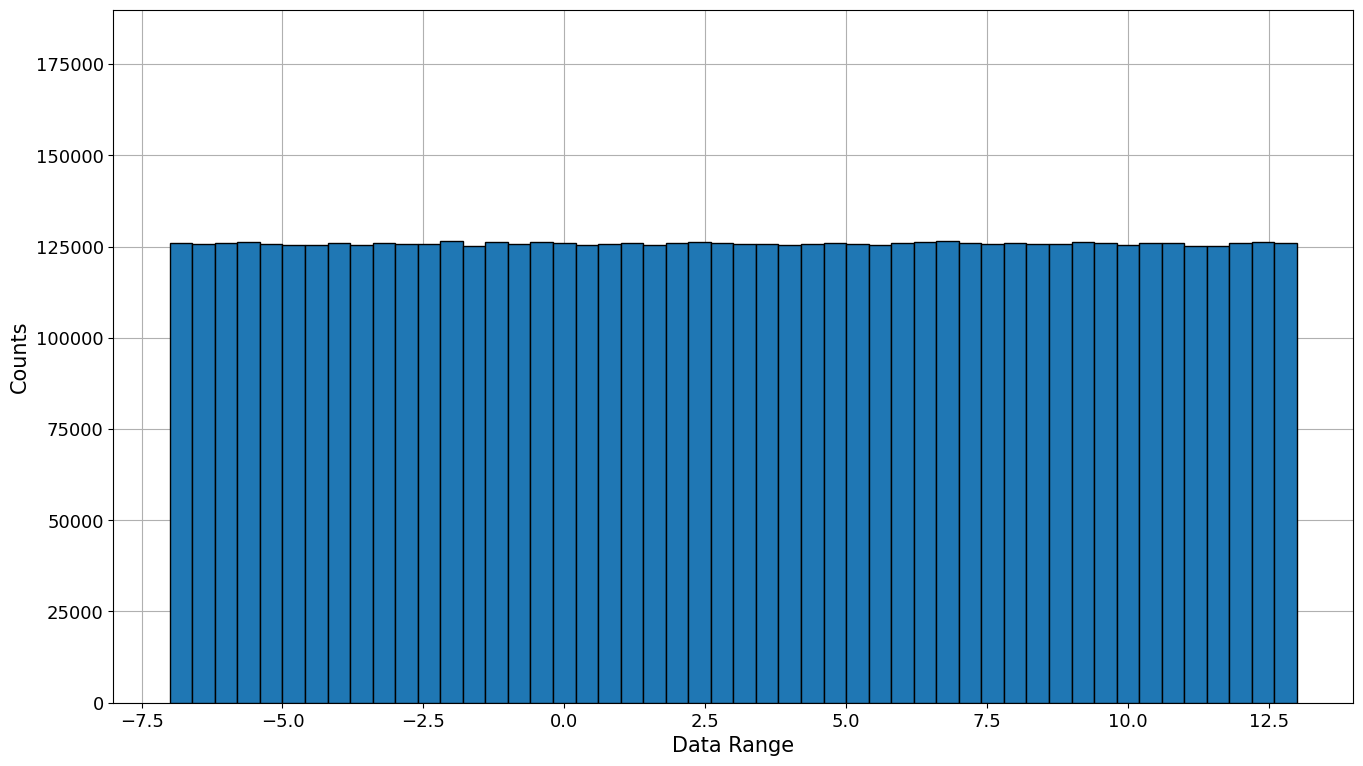

In [5]:
make_histogram(data["velocity"])

In [6]:
# Create a normalization transform:

normalize = Normalize(
    input_keys=["velocity", "pressure"],
    method="mean_std",
    # For real data, you'd compute these from your training set
    means={"velocity": 3.0, "pressure": 3.0},
    stds={"velocity": 5.77, "pressure": 5.77},
)

Apply the normalization to the data:

In [7]:
normalized_data = normalize(data)

In [8]:
print("After normalization:")
print(
    f"  velocity: mean={normalized_data['velocity'].mean():.4f}, std={normalized_data['velocity'].std():.4f}"
)
print(
    f"  pressure: mean={normalized_data['pressure'].mean():.4f}, std={normalized_data['pressure'].std():.4f}"
)
print()

After normalization:
  velocity: mean=-0.0001, std=1.0006
  pressure: mean=0.0004, std=1.0010



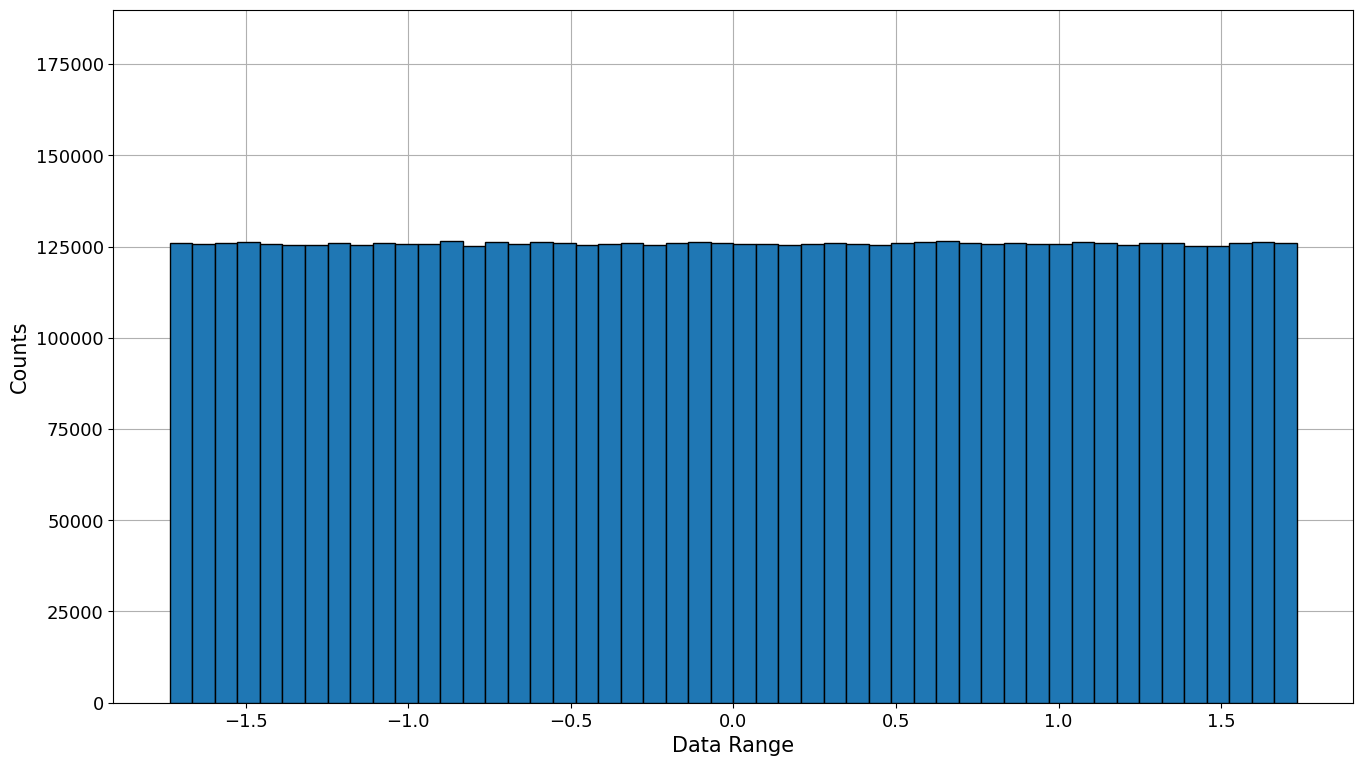

In [9]:
make_histogram(normalized_data["velocity"])

As you can see, the mean and std are very close to 0.0, 1.0.  The min/max is not, of course, since this is a uniform distribution.

Let's apply the min/max mode instead, now:

In [10]:
# Read fresh data:
data, metadata = reader[0]

print("Original min/max:")
print(f"\t{data['velocity'].min():.4f} to {data['velocity'].max():.4f}")

Original min/max:
	-7.0000 to 13.0000


In [11]:
# Demonstrate min-max normalization
print("Min-Max normalization example:")
normalize_minmax = Normalize(
    input_keys=["velocity"],
    method="min_max",
    mins={"velocity": -7.0},
    maxs={"velocity": 13.0},
)

minmax_data = normalize_minmax(data)
print(
    f"  velocity range: [{minmax_data['velocity'].min():.4f}, {minmax_data['velocity'].max():.4f}]"
)
print()

Min-Max normalization example:
  velocity range: [-1.0000, 1.0000]



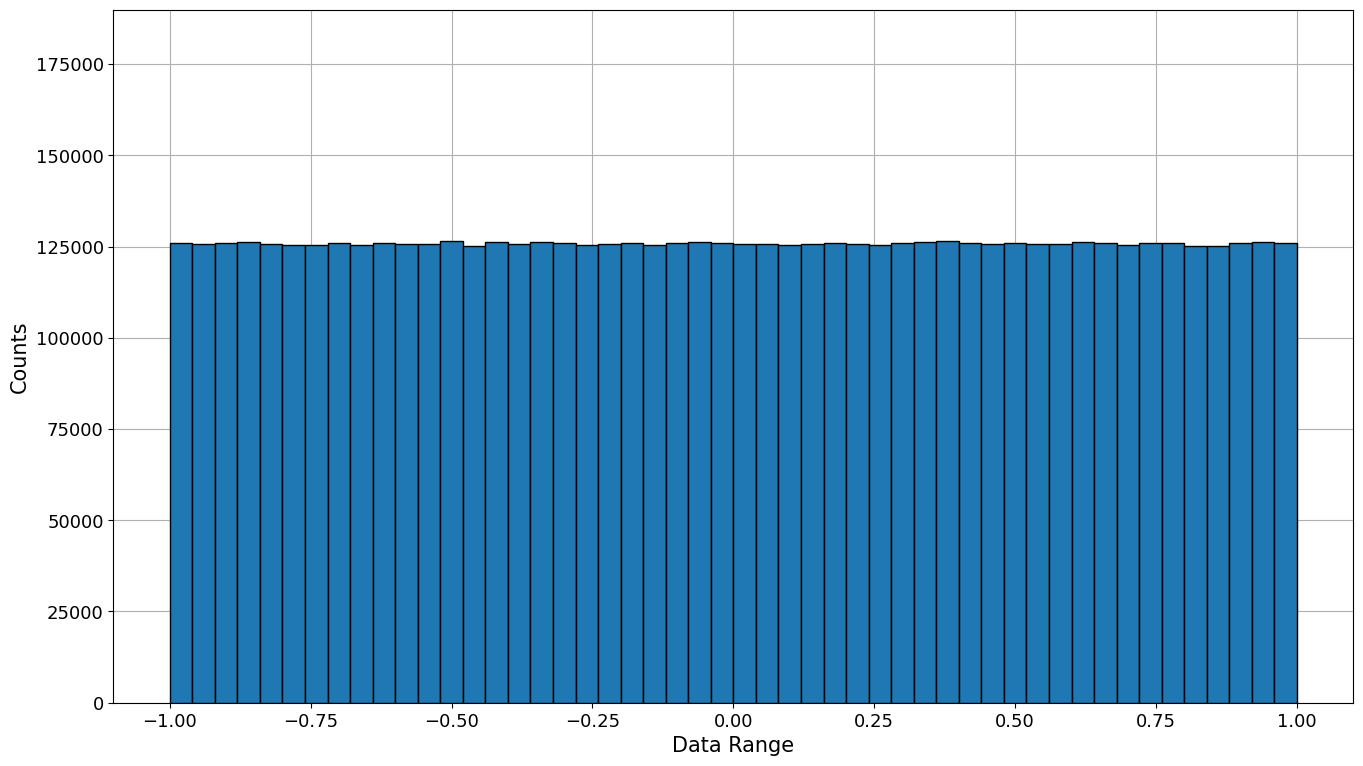

In [12]:
make_histogram(minmax_data["velocity"])

Min/max might feel incorrect here, but it helps to understand exactly what it's doing.  We have told the transform that the min/max of the dataset is -2 / 2, and so since the original range was _actually_ -1 to 1, it has applied the same scaling to that range that we request.  -2 is mapped to -1, but -1 is  mapped to -0.5.

## Section 2: Composing Multiple Transforms

The Compose class chains multiple transforms together, applying them
in sequence. This is similar to torchvision.transforms.Compose.

Transform pipelines are the recommended way to build preprocessing.

Create multiple transforms (note that we could just as easily combine the normalize transforms by passing a list of input keys):

In [13]:
normalize_velocity = Normalize(
    input_keys=["velocity"],
    method="mean_std",
    means={"velocity": 0.0},
    stds={"velocity": 0.6},
)

normalize_pressure = Normalize(
    input_keys=["pressure"],
    method="mean_std",
    means={"pressure": 0.0},
    stds={"pressure": 0.6},
)

# Compose them into a pipeline
transform_pipeline = Compose(
    [
        normalize_velocity,
        normalize_pressure,
    ]
)

In [14]:
print(f"Transform pipeline:\n{transform_pipeline}")
print()

# Apply pipeline to data
data, _ = reader[0]

print("Before pipeline:")
print(f"  velocity std: {data['velocity'].std():.4f}")
print(f"  pressure std: {data['pressure'].std():.4f}")

transformed_data = transform_pipeline(data)

print("After pipeline:")
print(f"  velocity std: {transformed_data['velocity'].std():.4f}")
print(f"  pressure std: {transformed_data['pressure'].std():.4f}")
print()

Transform pipeline:
Compose(
  (0): Normalize(method=mean_std, input_keys=['velocity'], eps=1e-08)
  (1): Normalize(method=mean_std, input_keys=['pressure'], eps=1e-08)
)

Before pipeline:
  velocity std: 5.7733
  pressure std: 5.7756
After pipeline:
  velocity std: 9.6221
  pressure std: 9.6261



A better approach is to use transforms directly with the dataset, which will apply them before returning the data:

In [15]:
# Better approach: Use transforms directly with Dataset
print("Using transforms with Dataset (recommended approach):")

dataset = Dataset(
    reader=reader,
    transforms=[normalize_velocity, normalize_pressure],
)

data, _ = dataset[0]
print(f"  velocity std: {data['velocity'].std():.4f}")
print(f"  pressure std: {data['pressure'].std():.4f}")
print()

dataset.close()

Using transforms with Dataset (recommended approach):
  velocity std: 9.6221
  pressure std: 9.6261



## Section 3: Subsampling Points

Another very common and useful transformation is the downsampling of spatial resolution through subsampling.  In this case, we'll use the synthetic point cloud data to subsample all the points to a consistent shape.

In [16]:
pointcloud_data_path = "./output/pointcloud_data/"

reader = ZarrReader(path=pointcloud_data_path, group_pattern="*.zarr")

# Load a sample to see its original size
data, metadata = reader[0]

print("Sample 1 Original point cloud:")
print(f"  coords shape: {data['coords'].shape}")
print(f"  features shape: {data['features'].shape}")
print()

data, metadata = reader[1]

print("Sample 2 Original point cloud:")
print(f"  coords shape: {data['coords'].shape}")
print(f"  features shape: {data['features'].shape}")
print()

Sample 1 Original point cloud:
  coords shape: torch.Size([65795, 3])
  features shape: torch.Size([65795, 8])

Sample 2 Original point cloud:
  coords shape: torch.Size([50860, 3])
  features shape: torch.Size([50860, 8])



Create a SubsamplePoints transform.  This samples the same indices from both coords and features:

In [17]:
subsample = SubsamplePoints(
    input_keys=["coords", "features"],  # Keys to subsample together
    n_points=10000,  # Target number of points
    algorithm="uniform",  # or "poisson_fixed" for very large data
)

print(subsample)

SubsamplePoints(input_keys=['coords', 'features'], n_points=10000, algorithm=uniform)


In [18]:
# Apply subsampling
subsampled_data = subsample(data)

print("After subsampling:")
print(f"  coords shape: {subsampled_data['coords'].shape}")
print(f"  features shape: {subsampled_data['features'].shape}")
print()

After subsampling:
  coords shape: torch.Size([10000, 3])
  features shape: torch.Size([10000, 8])



You can use subsampling in a dataset too:

In [19]:
dataset = Dataset(
    reader=reader,
    transforms=subsample,
)

# Iterate over a few samples
for i in range(3):
    data, _ = dataset[i]
    print(
        f"  Sample {i}: coords {data['coords'].shape}, features {data['features'].shape}"
    )

print()
dataset.close()

  Sample 0: coords torch.Size([10000, 3]), features torch.Size([10000, 8])
  Sample 1: coords torch.Size([10000, 3]), features torch.Size([10000, 8])
  Sample 2: coords torch.Size([10000, 3]), features torch.Size([10000, 8])



## Section 4: Geometric transforms

You may also want to apply geometric transforms to a dataset, on the fly, for example to remove the center-of-mass from a dataset and scale the data to a consistent size per batch.  We can build a pipeline to do exactly that:


In [20]:
data, _ = reader[0]

# Original statistics
print("Original coordinates:")
coords = data["coords"]
print(
    f"  Mean: [{coords[:, 0].mean():.4f}, {coords[:, 1].mean():.4f}, {coords[:, 2].mean():.4f}]"
)
print(f"  Min:  [{coords.min():.4f}]")
print(f"  Max:  [{coords.max():.4f}]")
print()

Original coordinates:
  Mean: [16.9967, 17.0051, 17.0076]
  Min:  [3.6032]
  Max:  [30.6863]



This is a tutorial, so let's shift the mean of the coordinates and rescale them arbitrarily:

In [21]:
data, _ = reader[0]

translate = Translate(
    input_keys=["coords"],
    center_key_or_value=torch.tensor([0.5, 0.5, 0.5]),  # Add this (shifts by 0.5)
)

translated_data = translate(data)
t_coords = translated_data["coords"]

print("After Translate([0.5, 0.5, 0.5]):")
coords = translated_data["coords"]
print(
    f"  Mean: [{coords[:, 0].mean():.4f}, {coords[:, 1].mean():.4f}, {coords[:, 2].mean():.4f}]"
)
print(f"  Min:  [{coords.min():.4f}]")
print(f"  Max:  [{coords.max():.4f}]")
print()

# Scale: scale coordinates by multiplying by a reference scale
rescale = Scale(
    input_keys=["coords"],
    scale=torch.tensor([0.5, 0.5, 0.5]),  # Multiple by this (scales by 2x)
)

rescaled_data = rescale(translated_data)
print("After Scale([0.5, 0.5, 0.5]):")
coords = translated_data["coords"]
print(
    f"  Mean: [{coords[:, 0].mean():.4f}, {coords[:, 1].mean():.4f}, {coords[:, 2].mean():.4f}]"
)
print(f"  Min:  [{coords.min():.4f}]")
print(f"  Max:  [{coords.max():.4f}]")
print()

After Translate([0.5, 0.5, 0.5]):
  Mean: [17.4967, 17.5051, 17.5076]
  Min:  [4.1032]
  Max:  [31.1863]

After Scale([0.5, 0.5, 0.5]):
  Mean: [8.7484, 8.7526, 8.7538]
  Min:  [2.0516]
  Max:  [15.5932]



Both Translation and scaling are available in an opposite mode, letting you change additions to subtractions and multiplications to divisions:

In [22]:
data, _ = reader[0]

translate = Translate(
    input_keys=["coords"],
    center_key_or_value=torch.tensor([0.5, 0.5, 0.5]),  # Add this (shifts by 0.5)
    subtract=True,  #### NOTE HERE!
)

translated_data = translate(data)
t_coords = translated_data["coords"]

print("After Translate([0.5, 0.5, 0.5]):")
coords = translated_data["coords"]
print(
    f"  Mean: [{coords[:, 0].mean():.4f}, {coords[:, 1].mean():.4f}, {coords[:, 2].mean():.4f}]"
)
print(f"  Min:  [{coords.min():.4f}]")
print(f"  Max:  [{coords.max():.4f}]")
print()

# Scale: scale coordinates by multiplying by a reference scale
rescale = Scale(
    input_keys=["coords"],
    scale=torch.tensor([0.5, 0.5, 0.5]),  # Multiple by this (scales by 2x)
    divide=True,  #### AND NOTE HERE!
)

rescaled_data = rescale(translated_data)
print("After Scale([0.5, 0.5, 0.5]):")
coords = rescaled_data["coords"]
print(
    f"  Mean: [{coords[:, 0].mean():.4f}, {coords[:, 1].mean():.4f}, {coords[:, 2].mean():.4f}]"
)
print(f"  Min:  [{coords.min():.4f}]")
print(f"  Max:  [{coords.max():.4f}]")
print()

After Translate([0.5, 0.5, 0.5]):
  Mean: [16.4967, 16.5051, 16.5076]
  Min:  [3.1032]
  Max:  [30.1863]

After Scale([0.5, 0.5, 0.5]):
  Mean: [32.9934, 33.0103, 33.0152]
  Min:  [6.2064]
  Max:  [60.3727]



This is meant to be combined with transforms that generate dynamic information.  For example, to compute and then subtract the center of mass in the datapipe:

In [23]:
transforms = Compose(
    [
        CenterOfMass(
            coords_key="coords",
            output_key="center_of_mass",
        ),
        Translate(
            input_keys=["coords"],
            center_key_or_value="center_of_mass",  # Use a key instead of a tensor!\
            subtract=True,
        ),
    ]
)

In [24]:
data, _ = reader[0]
com_subtracted = transforms(data)

In [25]:
print("After Scale([0.5, 0.5, 0.5]):")
coords = com_subtracted["coords"]
print(
    f"  Mean: [{coords[:, 0].mean():.4f}, {coords[:, 1].mean():.4f}, {coords[:, 2].mean():.4f}]"
)
print(f"  Min:  [{coords.min():.4f}]")
print(f"  Max:  [{coords.max():.4f}]")
print()

After Scale([0.5, 0.5, 0.5]):
  Mean: [-0.0000, 0.0000, 0.0000]
  Min:  [-13.3940]
  Max:  [13.6788]



You can see the shift is quite small since the data was randomly distributed about the origin, but due to finite statistics the mean was not exactly 0.  This transform calculated and shifted for us.

## Section 5: A complete transform pipeline in a training loop

Section 7: Complete Preprocessing Pipeline

This section demonstrates a realistic preprocessing pipeline combining
multiple transforms in a training-ready configuration.


In [26]:
reader = ZarrReader(path=pointcloud_data_path, group_pattern="*.zarr")

print("Building a complete preprocessing pipeline:")
print()
print("  Pipeline steps:")
print("    1. SubsamplePoints: Reduce to 10,000 points")
print("    2. CenterOfMass: Calculate the Center of Mass")
print("    3. Shift coords data to center of mass")
print("    3. Scale: Normalize spatial extent")
print("    4. Normalize: Standardize feature values")
print()

# Define transforms
transforms = [
    # Step 1: Subsample to manageable size
    SubsamplePoints(
        input_keys=["coords", "features"],
        n_points=10000,
        algorithm="uniform",
    ),
    CenterOfMass(
        coords_key="coords",
        output_key="center_of_mass",
    ),
    # Step 2: Translate (center at origin)
    Translate(
        input_keys=["coords"],
        center_key_or_value="center_of_mass",
    ),
    # Step 3: Scale coordinates (multiply by 0.5)
    Scale(
        input_keys=["coords"],
        scale=torch.tensor([0.5, 0.5, 0.5]),
    ),
    # Step 4: Normalize features
    Normalize(
        input_keys=["features"],
        method="mean_std",
        means={"features": 0.0},
        stds={"features": 0.58},
    ),
    Purge(keep_only=["features", "coords"]),
]

Building a complete preprocessing pipeline:

  Pipeline steps:
    1. SubsamplePoints: Reduce to 10,000 points
    2. CenterOfMass: Calculate the Center of Mass
    3. Shift coords data to center of mass
    3. Scale: Normalize spatial extent
    4. Normalize: Standardize feature values



Note the addition of the `Purge` transform at the end, where we explicitly specify to keep only the features and coordinates.  You can also `Rename` keys, or `Purge` in a `drop_only=[...]` format.

In [27]:
# Create dataset with the full pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = Dataset(
    reader=reader,
    transforms=transforms,
    device=device,
)

print(f"Dataset created on device: {device}")
print(f"Number of samples: {len(dataset)}")
print()

# Create DataLoader
dataloader = DataLoader(
    dataset=dataset,
    batch_size=4,
    shuffle=True,
)

print("Sample batch from DataLoader:")
batch_data = next(iter(dataloader))

for key in batch_data.keys():
    tensor = batch_data[key]
    print(f"  '{key}': shape={tensor.shape}, device={tensor.device}")
    print(f"          mean={tensor.mean():.4f}, std={tensor.std():.4f}")

print()

# Timing comparison
print("Performance comparison:")

# Time several iterations
start = time.time()
for i, batch_data in enumerate(dataloader):
    if i >= 4:
        break
    # Simulate some computation
    _ = batch_data["features"].sum()
elapsed = time.time() - start

print(f"  5 batches loaded and processed in {elapsed:.3f}s")
print(f"  Average time per batch: {elapsed / 5 * 1000:.1f}ms")
print()

dataset.close()
print("Pipeline complete!")
print()

Dataset created on device: cpu
Number of samples: 100

Sample batch from DataLoader:
  'features': shape=torch.Size([4, 10000, 8]), device=cpu
          mean=29.2960, std=5.1791
  'coords': shape=torch.Size([4, 10000, 3]), device=cpu
          mean=17.0048, std=1.4986

Performance comparison:
  5 batches loaded and processed in 0.222s
  Average time per batch: 44.3ms

Pipeline complete!

